In [1]:
# import libraries
# Always run this cell first!
import numpy as np
import pandas as pd
import math

import scipy
import statsmodels.api # appear to need to import the api as well as the library itself for the interpreter to find the modules
import statsmodels as sm

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline
import plotly.graph_objects as go
import plotly.offline
plotly.offline.init_notebook_mode(connected=True) # make plotly work with Jupyter Notebook using CDN

# an extra function for plotting a straight line
def plot_abline(slope, intercept, color = None, x_name = "x", y_name = "y"):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(
        x_vals, y_vals, '--', color = color,
        label = f"${y_name} = {slope:.2f}{x_name} " + ("-" if intercept < 0 else "+") + f"{abs(intercept):.2f}$"
    )

# Linear Regression

We next turn to explore another type of statistical decision-making tool, linear regression. Linear regression is a tool to allow us to explore the connections between 2 or more variables. 

## Simple Linear Regression

To begin, we'll look at simple linear regression, which models the linear association between two variables. This allows us to see how changes in one variable affect the other. To motivate the theory, we'll take a look at how statistics related to primary school education in a given country are associated with the literacy rate in that country.

### World Bank Development Indicators

The World Development Indicators dataset, maintained by the World Bank, contains information about a wide variety of topics related to global development. The [most recent version](https://datacatalog.worldbank.org/search/dataset/0037712) of the dataset, as of writing, provides over 1500 indicators for 217 economies from 1960 to 2021. The dataset is licensed under a [Creative Commons Attribution 4.0 International License](	https://datacatalog.worldbank.org/public-licenses#cc-by).

For our example, we will look at three statistics related to literacy. We will limit our analysis to the 89 countries that have valid data for all three statistics for at least one year in the time range 2017-2021. For each country, we will consider the most recent year from that time range for which all three statistics are available.

Let's take a look at this data, which is in a file called `world_bank_literacy.csv` (click [here](https://raw.githubusercontent.com/timothyprojectGiG/JB_Math_Textbook/main/src/ProbStat/StatInf/world_bank_literacy.csv) to download a copy).

In [2]:
wbl = pd.read_csv('world_bank_literacy.csv', index_col = 'country_code')
wbl.head()

,country,year,adult_literacy_rate_(pct),primary_school_completion_rate_(pct),primary_school_enrollment_rate_(pct)
country_code,,,,,
ALB,Albania,2021,98.449997,98.155830,95.921783
ARE,United Arab Emirates,2019,95.526482,111.938820,114.412361
ARG,Argentina,2018,99.003868,98.706253,109.659172
ARM,Armenia,2020,99.788612,93.165291,91.235443
AZE,Azerbaijan,2019,99.795982,100.383339,97.935349


Here is a brief summary of the information in the last three columns.

* The column labeled `adult_literacy_rate_(pct)` (World Bank indicator [SE.ADT.LITR.ZS](https://data.worldbank.org/indicator/SE.ADT.LITR.ZS)) contains the percentage of people age 15 and up in each country who are literate. The World Bank [defines](https://databank.worldbank.org/metadataglossary/world-development-indicators/series/SE.ADT.LITR.ZS) a person as literate if they can "read and write with understanding a short simple statement about their everyday life."

* The column labeled `primary_school_enrollment_rate_(pct)` (World Bank indicator [SE.PRM.ENRR](https://data.worldbank.org/indicator/SE.PRM.ENRR)) contains the gross percentage of people enrolled in primary school in each country. This percentage is [calculated](https://databank.worldbank.org/metadataglossary/world-development-indicators/series/SE.PRM.ENRR) by taking the total number of primary school students in a given country (no matter what their age is) and dividing it by the total number of people in the *official* age group for primary school in that country. Because some of the students in primary school might be older or younger than the official primary school ages, this percentage can be greater than 100%.

* The column labeled `primary_school_completion_rate_(pct)` (World Bank indicator [SE.PRM.CMPT.ZS](https://data.worldbank.org/indicator/SE.PRM.CMPT.ZS)) contains the gross percentage of people enrolled in the *last* grade of primary school in each country. This percentage is [calculated](https://databank.worldbank.org/metadataglossary/world-development-indicators/series/SE.PRM.CMPT.ZS) by taking the total number of non-repeating students in the last grade of primary school in a given country (no matter what their age is) and dividing it by the total number of people in the *official* age group for the last grade of primary school in that country. This percentage is not the actual rate of students who complete primary school, but it serves as a proxy (a variable we can measure that helps us approximate something else we can't measure) for that rate. As with `primary_school_enrollment_(pct)`, this percentage can be greater than 100% because some of the students in the last grade of primary school might be older or younger than the official age for that grade.

Let's suppose we are interested in literacy rates worldwide. We could begin our exploration by taking a look at some summary statistics:

In [4]:
wbl['adult_literacy_rate_(pct)'].describe()

count    89.000000
mean     85.170694
std      18.214867
min      26.760000
25%      76.570518
50%      94.971130
75%      98.419998
max      99.999947
Name: adult_literacy_rate_(pct), dtype: float64

*Note that since we take the average over *countries* in the sample, the average literacy rate here also refers to an average country. Since the average rate doesn't take into account the population of any country, it is not reflective of the overall worldwide literacy rate.*

An average country in our sample has a literacy rate of about 85%, and there is a fair bit of variation in the literacy rates. But what are some of the things that are connected with literacy rates in different countries? For example, maybe literacy rate is connected to the percentage of students in the country that complete primary schooling. We could explore this connection with a scatter plot:
(scatter-plot-simple)=

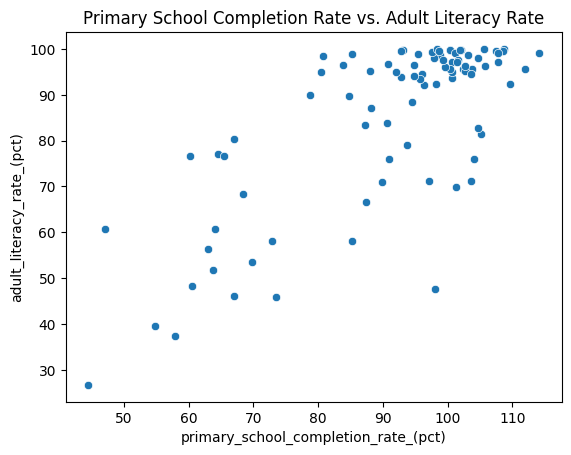

In [5]:
ax = sns.scatterplot(
    data = wbl,
    x = 'primary_school_completion_rate_(pct)',
    y = 'adult_literacy_rate_(pct)'
)
ax.set_title("Primary School Completion Rate vs. Adult Literacy Rate");

It looks like there is some connection here! As primary school completion rate increases, so does the literacy rate. We might call this a **positive trend**. Plus, it looks like you might be able to draw a line through the middle of this cloud of points to describe the way the cluster of points moves. So we might also call this a **linear trend**. We can describe this relationship in more depth using the tools of linear regression.

Note that just because these two variables seem to have some pattern when plotted together, that doesn't mean that primary school completion rate *causes* the change in literacy rate. It just means that primary school completion rate is *associated* with the change in literacy rate. (We'll use the word **association** to describe any pattern or connection between two variables, because "correlation is not causation".)

```{index} linear regression; simple models
```

### Simple Linear Regression Models

Simple linear regression is the method we have of modeling the linear association between two variables. You may have learned in algebra that one common way to write the equation of a line is the *slope-intercept form* $b + mx$. In this equation, $m$ is the slope, and the addition of $b$ means that the line passes through the point $(0,b)$, which is called the intercept of the line.

However, we can see from the [scatter plot](scatter-plot-simple) that our data points don't exactly fit a straight line. Instead, they seem to have some random deviations around a general trend line. We can write this *line-plus-random-error* idea using the mathematical equation

\begin{equation}
Y = \alpha + \beta x + \varepsilon.
\end{equation}

This is another type of statistical model, called a linear regression model. It says that the value of (the random variable) $Y$ is just the value along the line $\alpha + \beta x$ plus a random error $\varepsilon$. If we knew the slope $\beta$ and intercept $\alpha$ of the line, then we could plug in the value of $x$ to get a good guess for $Y$, though it would be off by some error.

You probably have many questions at this point, especially if this idea is new to you! But we want to first consider a big one: how do we figure out the equation for the line? There are multiple lines we could draw. Below are three of them. If you're following along in an interactive notebook, try playing around with the slope and intercept of the first line to see if you can make it fit the data as best you can.

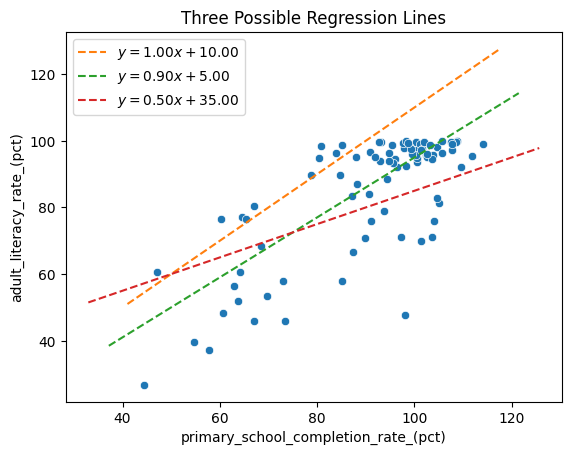

In [6]:
# Make your own line by changing around these numbers:
slope = 1.0
intercept = 10.0

# add scatter plot of data
palette = iter(sns.color_palette())
sns.scatterplot(
    data = wbl,
    x = 'primary_school_completion_rate_(pct)',
    y = 'adult_literacy_rate_(pct)',
    color = next(palette)
)

# plot the lines with given slope and intercept
# use function defined in first cell
plot_abline(slope, intercept, color = next(palette))
plot_abline(.9, 5.0, color = next(palette))
plot_abline(.5, 35, color = next(palette))
plt.title("Three Possible Regression Lines")
plt.legend();

Which of these lines is best? And what would make a line the "best" one in this situation? The method of least squares, described below, is a way to answer both of these questions.

```{index} sum of squares error
```
```{index} residuals
```

### Minimizing the Sum of Squares Error

If you spent some time thinking about where the "best" line should go, you probably tried to get it somewhere in the middle of the cloud of points, so that it wasn't too far away from any one point. In that way it would follow the general trend, even if it didn't exactly match any of the data points. 

We can make this idea more mathematical by considering something called the **residual**. For each country in our data set, we have a pair of primary school completion rates and literacy rates, which we could enumerate as pairs $(x_i,y_i)$. Given any line $\hat y = a + bx$, the residual is the difference between the actual value $y_i$ associated with $x_i$ in the data, and the value $\hat y_i$ that lies along the line $a + bx_i$ (that is, the residual is $y_i - \hat y_i$). In other words, the residual measures how far our line is from passing through a certain data point.

Below we look at plots of two different lines and examine the residuals associated with them. The residual for each point is the vertical distance from the point to the line. Which line do you think better fits the trend of the points? And what is the difference between the residuals of the two trend lines?

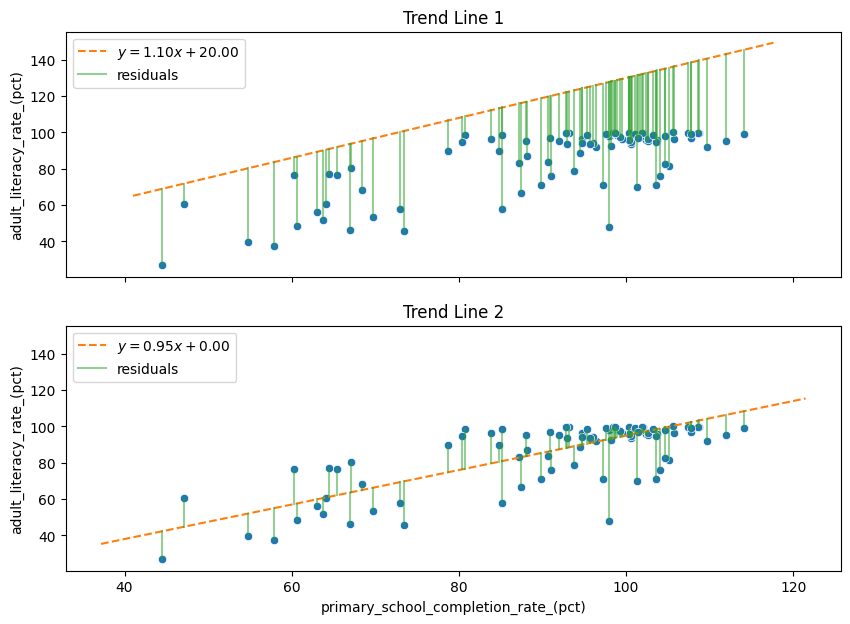

In [6]:
fig, axes = plt.subplots(2,1, sharex = True, sharey = True, figsize = (10,7))
slopes = [1.1, .95]
intercepts = [20, 0]
(scattercolor, trendcolor, residcolor) = sns.color_palette()[0:3]
for i in range(2):
    # set current axis
    plt.sca(axes[i])
    # plot data
    sns.scatterplot(
        data = wbl,
        x = 'primary_school_completion_rate_(pct)',
        y = 'adult_literacy_rate_(pct)',
        color = scattercolor,
    )
    # plot the line with given slope and intercept
    # use function defined in first cell
    plot_abline(slopes[i], intercepts[i], color = trendcolor)
    # plot residuals
    for j, (x, y) in enumerate(zip(wbl['primary_school_completion_rate_(pct)'], wbl['adult_literacy_rate_(pct)'])):
        plt.plot(
            [x, x], [y, slopes[i]*x + intercepts[i]],
            color = residcolor, alpha = 0.5,
            label = "residuals" if j == 0 else "" # show legend entry only for first residual in each plot
        )
    plt.legend(loc = "upper left")
    axes[i].set_title(f"Trend Line {i+1}")

```{index} regression; least-squares
```

The better trend line, Trend Line 2, has overall smaller residuals, so we might think that it would help  to pick the line that minimizes the sum of the residuals. This is *almost* the right idea! However, the worse line, Trend Line 1, has only negative residuals. So in fact the sum of its residuals is a negative number that will be smaller (at least on the number line) than the sum of the residuals of the better line.

It turns out we don't care about the sign of the residual, only its magnitude. To solve this issue, we square each of the residuals and take the sum to form a **sum of squared errors (SSE)**:

\begin{equation}
    SSE = \sum_{i=1}^n (y_i - \hat y_i)^2
\end{equation}

In the end, we want to find the slope and intercept of the line that minimizes this quantity. Since we are minimizing the sum of squared errors, this best-fit line also goes by the name **least-squares regression** line. Solving this problem looks like it could be tricky, but it turns out that the solution is straightforward when we employ the help of a little bit of calculus. Or, even nicer (in the author's opinion) is to use [a little algebra](../../Advanced/LinearAlgebra/OLS/jnb1.ipynb). We do need to assume that the random error $\varepsilon$ is normally distributed, but we will gloss over this assumption for now. You can read more about how to find the line of best fit elsewhere if you're interested, but here we'll simply find the solution using code.

Why take the sum of the squares of the residuals instead of the sum of the absolute values of the residuals? One reason is mathematical: there is always a unique global minimizer to the SSE. Since squaring a large number will make it larger, this method penalizes very large residuals. Another reason is statistical: it turns out the slope and intercept of the least squares solution have special mathematical properties which make them the *maximum likelihood estimators* of the model's true slope and intercept. But we won't look into that here!

### Finding the Least Squares Line

First, we can easily use software to get a visual of the least squares regression line using `seaborn`'s `lmplot`:

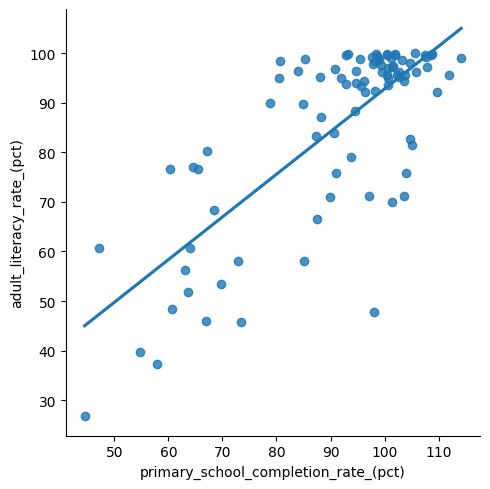

In [7]:
sns.lmplot(
    data = wbl,
    x = 'primary_school_completion_rate_(pct)',
    y = 'adult_literacy_rate_(pct)',
    ci = None
);

But what if we want to be more precise and want the equation of the line? For this, we'll use the `OLS` function from `statsmodels`. 

The `OLS` function is found in `statsmodels.regression.linear_model`, and it takes two arguments: the dependent variable $x$ and the independent variable $y$. Since we want a line that has an intercept, we plug our $x$ variable into the `add_constant` function to make sure we get the intercept term. This creates our "model object", which we named `lin_mod`. 

The linear model object `lin_mod` has a `fit()` function, which performs the least squares algorithm to find the equation of the line of best fit. The results of the algorithm can be printed out in a summary, which you see below. This is going to display a lot of output, but we'll walk through it slowly!

In [7]:
x = 'primary_school_completion_rate_(pct)'
y = 'adult_literacy_rate_(pct)'

lin_mod = sm.regression.linear_model.OLS(
    wbl[y], # the dependent variable (y)
    sm.tools.tools.add_constant(wbl[x]) # the independent variable (x)
)

results = lin_mod.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     adult_literacy_rate_(pct)   R-squared:                       0.567
Model:                                   OLS   Adj. R-squared:                  0.562
Method:                        Least Squares   F-statistic:                     114.0
Date:                       Mon, 05 Aug 2024   Prob (F-statistic):           1.70e-17
Time:                               15:57:52   Log-Likelihood:                -346.82
No. Observations:                         89   AIC:                             697.6
Df Residuals:                             87   BIC:                             702.6
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                    6.6714      7.462      0.894      0.374      -8.160      21.503
primary_school_completion_rate_(pct)     0.8615      0.081     10.677      0.000       0.701       1.022
==============================================================================
Omnibus:                       12.535   Durbin-Watson:                   1.772
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.251
Skew:                          -0.842   Prob(JB):                      0.00133
Kurtosis:                       3.861   Cond. No.                         540.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

There is a lot of information here, most of which we'll explain later on. For now, let's see how to get the information about the slope and the intercept of the line. You can find these values in the second table under the column heading `coef`. From this, we can see that the intercept (`const`) is 6.6714, and the slope associated with the primary school completion rate is 0.8615. We can write that in slope-intercept form as the line

\begin{equation}
    \hat y = 6.6714 + 0.8615 x
\end{equation}

Now that we have this line, how can we understand how to use it? First, the slope tells us how the changes in $x$ are connected to changes in $\hat y$. Here, an increase of 1% in the primary school completion rate ($x$) is associated with an average increase of about .865% in the literacy rate ($y$). 

The intercept is a bit harder to interpret in this context, but it's saying that in this model, a country with 0% primary school completion rate will, on average, have a literacy rate of 6.6714%. Of course, a 0% completion rate is much outside the range of values we have for $x$, and we don't recommend using the model to make predictions for that range of literacy rates! (That's called *extrapolation*.)

Next, we want to look at how well this model fits the data.

```{index} correlation coefficient
```

### $R^2$ and Goodness of Fit Tests

We mentioned before that we are using linear regression to *model* the relationship between two variables. But this only works if these variables actually have a linear relationship! Maybe they are actually related in a nonlinear way, or not related at all.

We can get some idea of this by looking at the [scatter plot](scatter-plot-simple), but we can also quantify the strength of a linear relationship through a number called the **correlation coefficient** $r$. The number $r$ is a value between $-1$ and $1$ that measures the strength of the linear association between two variables.

What's a large value of $r$ versus a small one? It depends on the problem! And as you get more comfortable with this, you'll get a sense for it. Below we'll take a closer look at how to understand this. As you look at these different plots, which would you say have a strong linear association?

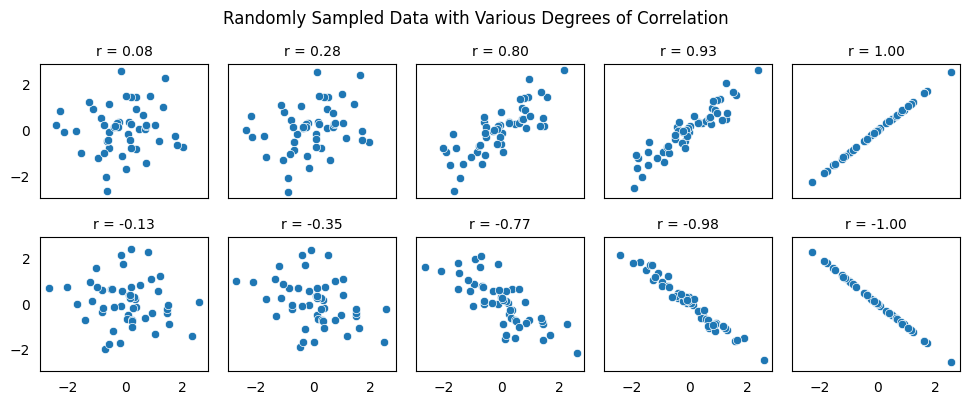

In [8]:
corrs = [0.03, 0.24, 0.78, 0.92, 1.0, -0.08, -0.31, -0.75, -0.98, -1.0]
rvs = None
# generate data
for corr in corrs:
    # create covariance matrix from correlation
    cov = np.tile([corr], (2,2))
    cov[np.diag_indices_from(cov)] = 1
    # generate random samples
    rv = scipy.stats.multivariate_normal.rvs(mean = [0,0], cov = cov, size = 50, random_state = 0)
    # add to dataframe
    df = pd.DataFrame(rv, columns = ["x", "y"])
    # calculate actual correlation of random sample
    df["r"] = f"{scipy.stats.pearsonr(df['x'], df['y'])[0]:.2f}"
    rvs = pd.concat([rvs, df]) if rvs is not None else df
# plot data
fg = sns.relplot(
    data = rvs,
    x = "x",
    y = "y",
    col = "r",
    col_wrap = 5,
    kind = "scatter",
    height = 2,
    facet_kws = { "despine": False }
)
# clear axis labels and remove tick marks
fg.set_axis_labels("", "")
fg.tick_params(axis = "both", left = False, bottom = False)
fg.figure.suptitle("Randomly Sampled Data with Various Degrees of Correlation", y = 1.05);

When we emphasize that $r$ measures *linear* association, this means that two variables might have a very small value of $r$, but still have some *nonlinear* association. Notice in the following scatter plot that the points have a quadratic relationship, but the measure of correlation is close to 0. 

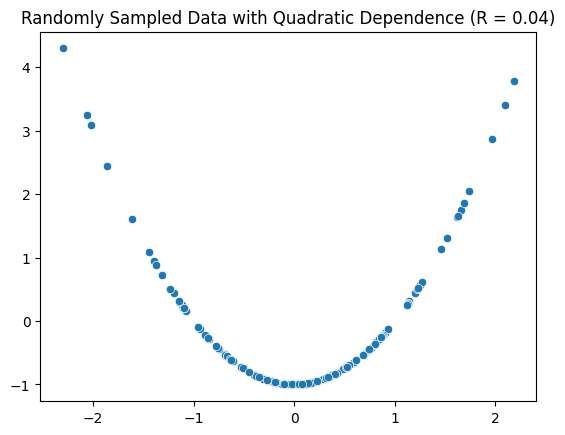

In [9]:
# generate and plot randomly sampled data from two quadratically dependent random variables with zero covariance
x = np.array(scipy.stats.norm.rvs(size = 150, random_state = 1))
y = x**2 - 1
corr = scipy.stats.pearsonr(x, y)[0]
ax = sns.scatterplot(
    x = x,
    y = y,
)
ax.set_title(f"Randomly Sampled Data with Quadratic Dependence (R = {corr:.2f})");

There are a few ways to calculate $r$ in Python. First, we could calculate it directly using the `pearsonr` command from `scipy.stats`:

In [12]:
x = wbl['primary_school_completion_rate_(pct)']
y = wbl['adult_literacy_rate_(pct)']
r = scipy.stats.pearsonr(x, y)[0]

r

0.7531156213152443

Second, we also get the magnitude of $r$ in the output of our linear model. If you look above, you see that the output of the linear model says `R-squared: 0.567`. This actually provides you with a value $r^2$, which is simply the square of the correlation coefficient $r$ that we calculated above:

In [13]:
r**2

0.5671831390690465

Even though it doesn't tell us if the trend is positive or negative, $r^2$ is often preferred to $r$ because it has a simple interpretation. The value of $r^2$ quantifies the **percentage of variation in $Y$ that is explained by the linear model.**

In the context of our problem, using a linear model with the primary school completion rate explains 56.7% of the variation in literacy rates between the countries. More simply, the primary school completion rate explains some of the differences in literacy rates between countries, but not all, and that amount is quantified as 56.7%.

Is this a small or large amount? One way to quantify how well the model fits is through a *Goodness of Fit Test*. Without giving all of the details, this is a hypothesis test that determines if the value of $r$ is significantly different from 0. In terms of hypotheses, the null hypothesis is that the model is not a good fit, versus the alternative that it is a good fit.

The test statistic has a special type of distribution called an F distribution, and its value can be found on the right of the summary table as `F-statistic`. The $P$-value for the test is right below it. In this case an F statistic of 114.0 yields a $P$-value of $1.70\times 10^{-17}$, which is very small. Hence, we reject the null hypothesis, and conclude that this linear model fits the data well.

There is a lot more to these kinds of tests, which become more important in the multiple regression case. We'll come back to that later on!

### Inference on Model Parameters

Now that we know how to find the line of best fit, we want to know how good our estimates of the slope and intercept are. We began by assuming that there is a linear model describing the relationship between $x$ and $Y$:

\begin{equation}
Y = \alpha + \beta x + \varepsilon.
\end{equation}

Because we only have limited data on the relationship between these two variables $x$ and $Y$, we can't calculate $\alpha$ and $\beta$ exactly, but only estimate them with our least squares estimates $a$ and $b$. How can we know how good these estimates actually are? We turn again to our statistical inference tools of the confidence interval and hypothesis test.

A big question in linear regression is whether knowing the value of $x$ makes a difference in our estimation of $Y$. If it doesn't, the slope value in the model would actually be 0. If it does, it would be something different from 0. But $\beta$ is a parameter of the model, which we estimated by calculating the slope $b$ using least squares. So we can use our hypothesis testing skills to decide if $\beta = 0$ or not!

\begin{equation}
    H_0: \beta = 0, \\ H_1: \beta \neq 0.
\end{equation}

We can show that the test statistic for this hypothesis test is a T random variable, and its value is given in the model summary readout. Look for the column `t`, just two columns to the right of where you found the coefficients. And just next to that is the $P$-value for the test.

In this case, we got $T=10.677$ which yields a $P$-value of 0.000. This causes us to reject the null hypothesis and conclude that the true slope is actually different from 0. We can also give a 95% confidence interval for our estimate of the slope, which is again given in the table as $(0.701, 1.022)$.

If this seems similar to the goodness of fit test we just covered, you're right! In fact, they are exactly the same in the simple linear regression case (verify for yourself that $F = T^2$). However, once we move to the multiple regression case, they will no longer be the same, and both tests will be important!

Before moving on, take some time to look over the model summary output again, and make sure that you can find all the information we've talked about so far.

### Model Diagnostics

To wrap up our discussion of simple linear regression, we need to address a few details that we have glossed over up to this point. In our previous discussion, we have made a few assumptions which we need to take a deeper look at.

We assumed:

1. $Y$ and $x$ really do have a linear relationship. We made this assumption when we decided to use the model $Y = \alpha + \beta x + \varepsilon$.
2. The random error $\varepsilon$ is normally distributed with mean 0.
3. The random error $\varepsilon$ is independent of $x$. 

These last two assumptions were not explicitly stated, but they are needed to make the regression interpretations work. And when we make assumptions like this, we need to check to see if these are reasonable! Here, we will show how to visually evaluate these assumptions using graphs.

The first question of the relationship between $Y$ and $x$ can be easily evaluated through the [scatter plot](scatter-plot-simple) we made at the beginning of this section. If the scatter plot isn't clear, then the correlation coefficient can help!

We can evaluate the next two claims by examining the residuals. The residuals are related to the random error since, according to the model,

\begin{equation}
    y_i - \hat y_i =  y_i - (a + b x_i) \approx y_i - (\alpha + \beta x_i) = \varepsilon_i.
\end{equation}

Plotting the residuals will give us an idea about the distribution of the $\varepsilon$, but we need two different types of plots to examine the assumptions.

First, we can plot a histogram of the residuals:

In [16]:
results.resid


country_code
ALB     7.220704
ARE    -7.576385
ARG     7.300405
ARM    12.858499
AZE     6.647767
         ...    
URY     3.107952
UZB     2.338211
WSM    -5.924394
ZAF     9.097157
ZWE     9.960256
Length: 89, dtype: float64

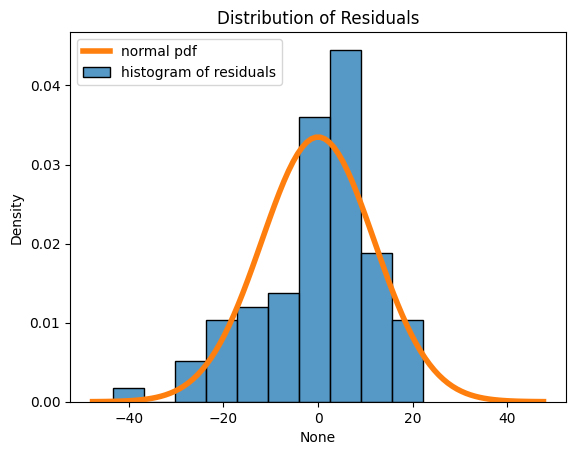

In [17]:
palette = iter(sns.color_palette())
sns.histplot(
    x = results.resid,
    stat = 'density',
    color = next(palette),
    label = "histogram of residuals",
)
std = np.std(results.resid)
x = np.linspace(-std*4, std*4, 100)
plt.plot(
    x,
    scipy.stats.norm.pdf(x, loc=np.mean(results.resid), scale=std),
    color = next(palette),
    linewidth = 4,
    label = "normal pdf"
)
plt.title("Distribution of Residuals")
plt.legend();

Here we see that the residuals have a roughly mound-shaped distribution, though there is left skew and the histogram does deviate somewhat from the normal distribution. We will say that the normal residual assumption is ok in this case, even though the residuals don't follow the normal distribution as much as we might like!

Second, we look at a scatter plot between $x$ and the residuals. If the errors are truly independent of $x$, then we will not observe any patterns in the graph, and it should look like a random cloud of points. There should be roughly an equal number spread out above and below 0, with most of them being close to 0.

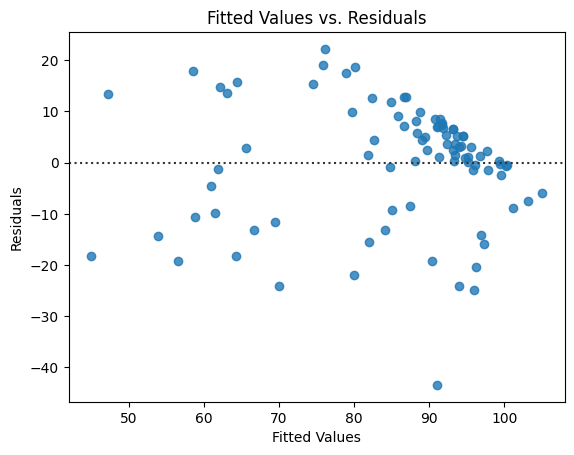

In [18]:
ax = sns.residplot(
    x = results.fittedvalues,
    y = results.resid,
)
ax.set_xlabel('Fitted Values')
ax.set_ylabel('Residuals')
ax.set_title("Fitted Values vs. Residuals");

Here there isn't a clear pattern, though the cluster of points in the upper right might give us some pause. Again it looks like the assumptions are reasonable, though that cluster means we should be cautious in this case about the fit of the model.

It can take some time to develop intuition about which plots look "good enough" and which are really bad, and there are some more sophisticated tests for these things that are outside the scope of this book. To illustrate the point, we provide an example below of what would it look like if the assumptions were badly violated, using a different variable from our data for the $x$-axis. Here is the model using this other variable:

In [21]:
x = 'primary_school_enrollment_rate_(pct)'
y = 'adult_literacy_rate_(pct)'
model = sm.regression.linear_model.OLS(wbl[y], sm.tools.tools.add_constant(wbl[x]))
results = model.fit()
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     adult_literacy_rate_(pct)   R-squared:                       0.000
Model:                                   OLS   Adj. R-squared:                 -0.011
Method:                        Least Squares   F-statistic:                  0.003546
Date:                       Sun, 04 Aug 2024   Prob (F-statistic):              0.953
Time:                               19:55:57   Log-Likelihood:                -384.08
No. Observations:                         89   AIC:                             772.2
Df Residuals:                             87   BIC:                             777.1
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                   86.0796     15.388      5.594      0.000      55.495     116.664
primary_school_enrollment_rate_(pct)    -0.0088      0.148     -0.060      0.953      -0.303       0.286
==============================================================================
Omnibus:                       22.660   Durbin-Watson:                   1.728
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.654
Skew:                          -1.356   Prob(JB):                     3.64e-07
Kurtosis:                       3.800   Cond. No.                         823.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

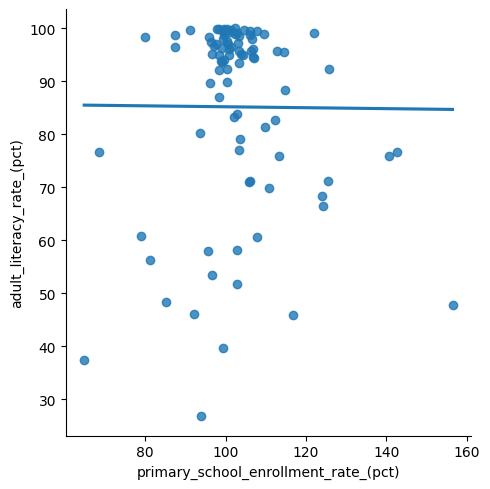

In [20]:

sns.lmplot(
    data = wbl,
    x = x,
    y = y,
    ci = None,
);

And here are the model diagnostic plots for this other model. Notice that the spread of the residuals is skewed and that the distribution does not look normal, violating our regression assumptions.

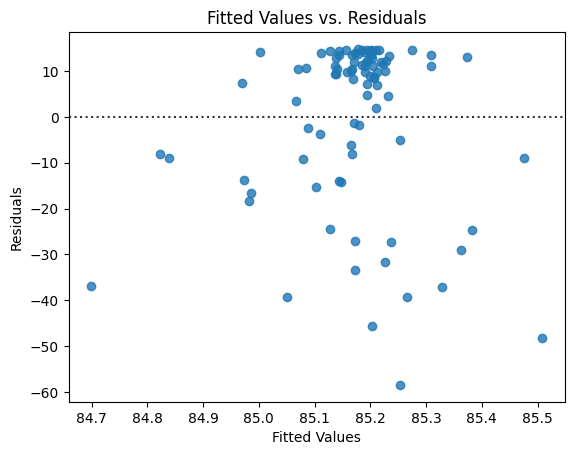

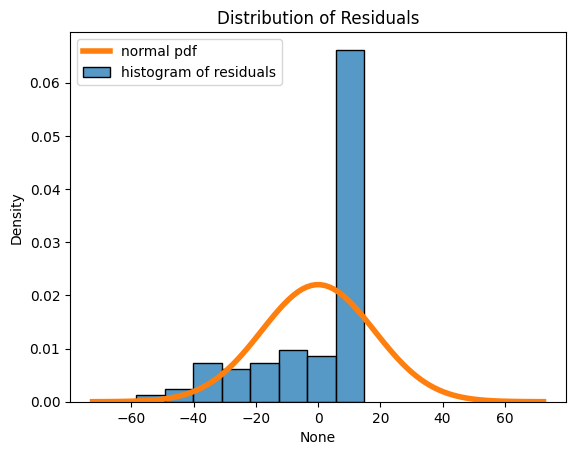

In [23]:
# plot residuals scatterplot
fig, ax = plt.subplots()
sns.residplot(
    x = results.fittedvalues,
    y = results.resid,
    ax = ax,
)
ax.set_xlabel('Fitted Values')
ax.set_ylabel('Residuals')
ax.set_title("Fitted Values vs. Residuals");

# plot residuals histogram
fig, ax = plt.subplots()
palette = iter(sns.color_palette())
sns.histplot(
    x = results.resid,
    stat = 'density',
    color = next(palette),
    label = "histogram of residuals",
)
std = np.std(results.resid)
x = np.linspace(-std*4, std*4, 100)
plt.plot(
    x,
    scipy.stats.norm.pdf(x, loc=np.mean(results.resid), scale=std),
    color = next(palette),
    linewidth = 4,
    label = "normal pdf"
)
plt.title("Distribution of Residuals")
plt.legend();

In summary, if all of the diagnostic plots look ok, then the assumptions are reasonable, and our modeling results can be trusted! If not, there are other things you can try, but that is outside the scope of this section. It can take some time to get the hang of looking at these plots, but the more you practice the easier it becomes.

### Exercise 1

What sorts of team statistics are associated with winning in the English Premier League? We can explore this question at a high level using simple linear regression.

Below, we load a dataset from the file `epl_table_22_23.csv` (click [here](https://raw.githubusercontent.com/timothyprojectGiG/JB_Math_Textbook/main/src/ProbStat/StatInf/epl_table_22_23.csv) to download a copy). This dataset contains the league standings along with some common statistics for the 2022-23 EPL season. A few notes:

- `points` is the total number of points accrued by a team through winning or drawing matches. A team earns 1 point for a draw and 3 points for a win.
- `goals_for` is the number of goals scored by the team, while `goals_against` is the number of goals allowed by the team. `goal_diff` is how many more (or less) goals a team scored than allowed.

In [24]:
epl = pd.read_csv('epl_table_22_23.csv')
epl.head()

,team,wins,draws,losses,points,goals_for,goals_against,goal_diff,expected_goals_for,expected_goals_against,expected_goal_diff,attendance
0,Arsenal,26,6,6,84,88,43,45,71.9,42.0,29.9,60191
1,Aston Villa,18,7,13,61,51,46,5,50.2,52.5,-2.2,39485
2,Bournemouth,11,6,21,39,37,71,-34,38.6,63.9,-25.3,10362
3,Brentford,15,14,9,59,58,46,12,56.8,49.9,6.8,17078
4,Brighton,18,8,12,62,72,53,19,73.3,50.2,23.1,31477


1. Make a scatter plot of the number of goals a team scored (`goals_for`) versus the number of points they accrued in the standings (`points`). How would you describe the relationship?
2. Fit a linear model to these two variables, and print out the summary.
3. Use the summary to write down the estimated slope and intercept of the model. Interpret these values in the context of the problem. How many points, on average, is each additional goal scored in the standings worth?
4. What is the value of $r^2$? Does the model seem to be a good fit? Explain your reasoning.
5. Provide diagnostic plots for the model and comment on the validity of the assumptions.
5. Repeat this analysis with another variable or variables. Do your new models seem to be a better or worse fit? Why or why not? Provide diagnostic plots for your model and comment on the validity of the assumptions.
6. Do you think `attendance` has any effect on a team's performance? Use some of the tools from this section to answer, and explain what you find. How might you use this example to help understand the common phrase "correlation is not causation"?

```{index} regression; multiple
```

## Multiple Regression

Much more interesting is the case where there are several independent variables that are all possibly connected to an output. In this case, because we are dealing with multiple variables, our modeling tool is now called **multiple regression**.

For our example, we will return to the [Palmer Penguins dataset](https://github.com/mcnakhaee/palmerpenguins) introduced in the [previous section](03_Inference_Numerical.ipynb). Specifically, we will look at the connection between body mass and some of the other measurements of the penguins.

This becomes a bit more difficult to visualize since we are dealing with more than just 2 variable dimensions.

In [26]:
from palmerpenguins import load_penguins

penguins = load_penguins()
penguins.sample(5).head() # display 5 randomly sampled rows

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
328,Chinstrap,Dream,45.7,17.3,193.0,3600.0,female,2009
107,Adelie,Biscoe,38.2,20.0,190.0,3900.0,male,2009
54,Adelie,Biscoe,34.5,18.1,187.0,2900.0,female,2008
126,Adelie,Torgersen,38.8,17.6,191.0,3275.0,female,2009
195,Gentoo,Biscoe,49.6,15.0,216.0,4750.0,male,2008


So what does it look like to understand how body mass changes based on these other variables? Mathematically, we are modeling $Y$ as a linear function of several independent variables $x_1, x_2, \ldots, x_p$. As in the single variable case, our variable $Y$ won't follow this linear function exactly. Instead, it will be subject to some random deviations, modelled by $\varepsilon$.

\begin{equation}
    Y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \ldots + \beta_p x_p + \varepsilon.
\end{equation}

Again, we only have limited data, so we need to *estimate* the values of $\beta_0, \ldots, \beta_p$ with some estimators $b_0, \ldots, b_p$. As a result, our new equation looks like this:

\begin{equation}
    \hat y = b_0 + b_1 x_1 + b_2 x_2 + \ldots + b_p x_p.
\end{equation}

In this equation, $b_0$ is an intercept, while $b_1, \ldots, b_p$ are slope parameters associated with the different variables $x_1, \ldots, x_p$. For example, the value of $b_3$ tells us how much we estimate that $Y$ would change when $x_3$ changes, *with all other independent variables held constant*. Thinking about this in the abstract setting can be difficult, so we recommend coming back to this later in light of the example using real data below.

So how do we find this 'best' linear function? The good news is that we can do this estimation using least squares! Similar to the one-variable case, this involves finding the values of $b_0, \ldots, b_p$ that minimize the sum of the squared residuals:

\begin{equation}
    \min_{b_0, \ldots, b_p} \sum_{i=1}^n (y_i - \hat y_i)^2
\end{equation}

We'll spare you the details in this section, as the notation can get messy and a full solution requires the use of linear algebra. You can find the details in most any college linear algebra book, including [this section](../../Advanced/LinearAlgebra/OLS/jnb1.ipynb) of this book.

Again, we have some code that can take care of this least squares minimization for us and find the estimates we need. As before, we'll use the `statsmodels` library, but when we specify the input variables `x`, we list each of the variables we are using to try to understand body mass. In this case, we start by looking at just bill depth and flipper length.

Note that we also add `missing = 'drop'` since a few of these data points are missing, which means we need to tell the computer to ignore those rows!

In [27]:
x = penguins[['bill_depth_mm', 'flipper_length_mm']]
y = penguins['body_mass_g']
model1 = sm.regression.linear_model.OLS(y, sm.tools.tools.add_constant(x), missing='drop')
results = model1.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            body_mass_g   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     539.8
Date:                Sun, 04 Aug 2024   Prob (F-statistic):          4.23e-106
Time:                        20:03:01   Log-Likelihood:                -2527.0
No. Observations:                 342   AIC:                             5060.
Df Residuals:                     339   BIC:                             5071.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -6541.9075    540.751    -12.098      0.000   -7605.557   -5478.258
bill_depth_mm        22.6341     13.280      1.704      0.089      -3.488      48.756
flipper_length_mm    51.5414      1.865     27.635      0.000      47.873      55.210
==============================================================================
Omnibus:                        5.490   Durbin-Watson:                   2.069
Prob(Omnibus):                  0.064   Jarque-Bera (JB):                5.361
Skew:                           0.305   Prob(JB):                       0.0685
Kurtosis:                       3.067   Cond. No.                     5.14e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.14e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Again, there is a lot of information here! First, we can take the coefficients to see that the estimated relationship between body mass ($Y$) and the bill depth ($x_1$) and flipper length ($x_2$) is

\begin{equation}
\hat y = -6541.91 + 22.63 x_1 + 51.54 x_2
\end{equation}

This means that, on average, an increase of 1mm of bill depth is associated with an increase of about 23g in mass, at least for two penguins with the same flipper length. Likewise, holding bill depth constant, an increase of 1mm in flipper length is associated with an increase of about 52g in mass. 

However, if we take a look at the P-values (in the `P>|t|` column), we see that the coefficient for `bill_depth_mm` has a value of 0.089. This is a somewhat large P-value, which indicates that the variable `bill_depth_mm` does not have a significant effect on `body_mass_g` in the presence of the other variable, `flipper_length_mm`. In other words, `bill_depth_mm` does not add any additional information beyond what `flipper_length_mm` already offers to our model for body mass. (See what happens when you exclude bill depth from the model!)

At this point, we have only one variable that seems to be associated with body mass. However, there is more we can do here. (And don't worry, I haven't forgotten about model assumptions and diagnostics---we'll come back to that soon!)

```{index} dummy variables
```

### Dummy Variables

Categorical or qualitative variables can sometimes also be incorporated into a linear regression model by an appropriate transformation. In this case, we have at least one such variable that might be helpful in understanding body mass. Male penguins are typically larger than female penguins, so it might be helpful to incorporate the `sex` of the penguin into our model.
(scatter-plot-multiple)=

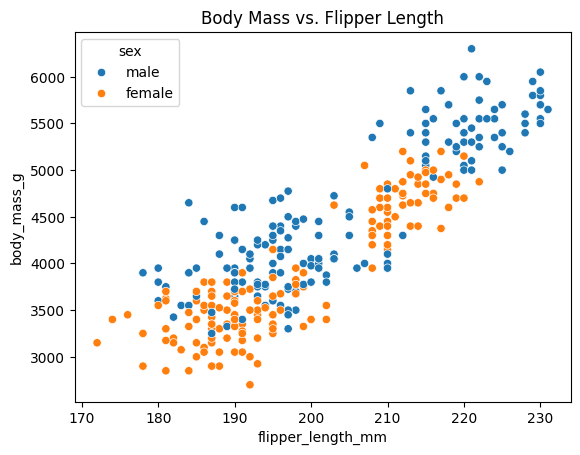

In [28]:
ax = sns.scatterplot(
    data = penguins,
    x = 'flipper_length_mm',
    y = 'body_mass_g',
    hue='sex'
)
ax.set_title("Body Mass vs. Flipper Length");

However, this variable doesn't consist of numerical values. Instead, it consists of a set of categorical values (`male` and `female` in this case), which are referred to as the "levels" of the variable. So it's not clear how we can incorporate this variable into the linear model as-is.

To solve this problem, we will "encode" the levels of this categorical variable as numbers. This process is called adding a "dummy" variable. To do this, we'll use the `get_dummies` function from the `pandas` library:

In [29]:
x = penguins[['sex', 'flipper_length_mm']]
y = penguins['body_mass_g']

x = pd.get_dummies(x, drop_first="TRUE", dtype=int)
x.head(10)

,flipper_length_mm,sex_male
0,181.0,1
1,186.0,0
2,195.0,0
3,NaN,0
4,193.0,0
5,190.0,1
6,181.0,0
7,195.0,1
8,193.0,0
9,190.0,0


In this case, we see that we have created a new dummy variable `sex_male`. This is a variable that takes the value 1 if the sex of the penguin is male and 0 otherwise. (There is nothing special about whether male or female is 0 or 1; the software chooses automatically based on which levels appear first in the data.)

So now we have turned our categorical variable into a numerical one, which we can add to the model. Let's see what it looks like!

In [30]:
model2 = sm.regression.linear_model.OLS(y, sm.tools.tools.add_constant(x), missing='drop')
results = model2.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            body_mass_g   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     691.0
Date:                Sun, 04 Aug 2024   Prob (F-statistic):          2.53e-120
Time:                        20:03:54   Log-Likelihood:                -2493.9
No. Observations:                 342   AIC:                             4994.
Df Residuals:                     339   BIC:                             5005.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -5327.2009    281.739    -18.908      0.000   -5881.378   -4773.024
flipper_length_mm    46.5787      1.420     32.795      0.000      43.785      49.372
sex_male            347.2632     39.891      8.705      0.000     268.797     425.729
==============================================================================
Omnibus:                        0.303   Durbin-Watson:                   1.744
Prob(Omnibus):                  0.860   Jarque-Bera (JB):                0.412
Skew:                           0.057   Prob(JB):                        0.814
Kurtosis:                       2.874   Cond. No.                     2.94e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.94e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Take a look at the output of this new model. One way to think about this is that there are two lines, one for each category (male and female). If the penguin is male ($x_2 = 1$), the regression line looks like

\begin{equation}
\hat y_{male} = -5327.20  + 46.58 x_1 + 347.26 x_2 = -5327.20  + 46.58 x_1 + 347.26(1) = -4979.94 + 46.58 x_1.
\end{equation}

For a female penguin, on the other hand, the variable $x_2$ would take a value of 0. See if you can write down the estimated line for a female penguin.

You can also simply interpret the coefficient of `sex_male` to mean that male penguins are on average 347.26g heavier than female penguins when controlling for bill depth.

Notice that we only needed 1 dummy variable to describe a categorical variable with two possible levels. In general, we need to create one fewer variable than the number of levels in the variable. This is what the `drop_first=TRUE` argument does: it drops one of the dummies that isn't necessary in the model. In the exercises, you'll see what happens when we add in a categorical variable with 3 levels (`species`, which has levels `Gentoo`, `Adelie`, or `Chinstrap`). 

### Model Diagnostics

The assumptions for a multiple linear regression model are nearly the same as for a simple linear regression model, and they are not much more difficult to evaluate. Once again, we need to assume that the relationship between $Y$ and the input variables $x_1, \ldots, x_p$ is linear. And as before, we can check this assumption by looking at the [scatter plot](scatter-plot-multiple) we made.

We also need to assume that the residuals are nearly normal and independent of the input variables. Coding the plots to check these last two assumptions looks much the same as it did before.

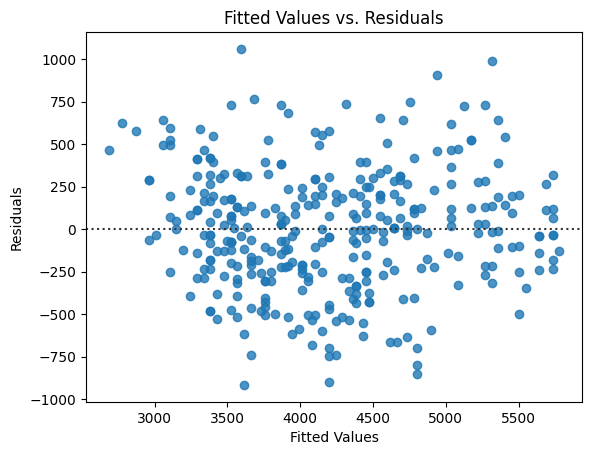

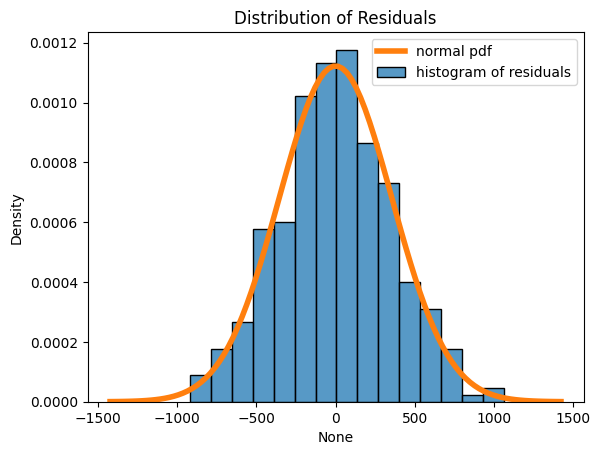

In [31]:
# plot residuals scatterplot
fig, ax = plt.subplots()
sns.residplot(
    x = results.fittedvalues,
    y = results.resid,
    ax = ax,
)
ax.set_xlabel('Fitted Values')
ax.set_ylabel('Residuals')
ax.set_title("Fitted Values vs. Residuals")

# plot residuals histogram
fig, ax = plt.subplots()
palette = iter(sns.color_palette())
sns.histplot(
    x = results.resid,
    stat = 'density',
    color = next(palette),
    label = "histogram of residuals",
)
std = np.std(results.resid)
x = np.linspace(-std*4, std*4, 100)
plt.plot(
    x,
    scipy.stats.norm.pdf(x, loc=np.mean(results.resid), scale=std),
    color = next(palette),
    linewidth = 4,
    label = "normal pdf"
)
plt.title("Distribution of Residuals")
plt.legend();

It's pretty clear that the residuals are nearly normal and that there is no pattern. In fact, this looks much better than the plots of the residuals for the simple linear regression models, indicating that in some respects the linear model is a better fit here.

But we've glossed over something important! If you looked closely at the [original scatter plot](scatter-plot-multiple), you probably noticed that male penguins don't just have larger body mass, they also have larger flipper length. In other words, the input variables `sex` and `flipper_length_mm` are themselves correlated, which could be causing an issue in our model. (Note that the model readout also indicates that this might be a problem.) We can get a better look at this through some [exploratory data analysis](../../Data.md). But for now, let's move on to some other topics. 

### Inference on Model Parameters

The techniques of inference that we talked about in the single-variable case carry over to the multiple regression model. The main difference is the interpretation of the readout results. Because we have multiple variables involved in the model, which themselves may be linearly connected, the matter becomes slightly more complex.

First, we might ask how well the model is doing overall. How well does it fit the data? The software has again performed the *Goodness of Fit Test* for us, comparing (in basic terms) the null hypothesis that the model is not a good fit versus the alternative hypothesis that it is a good fit. Looking back at the model readout, we can find that our F-statistic is 691.0, yielding an extremely small P-value of $2.53\times10^{-120}$ (0, for our purposes). This means that our model is a good fit and that our input variables are providing some information about `body_mass_g`.

This test looks at the fit of the model all at once, but we can also look in more detail at the values of the individual "slope" coefficients associated with each input. The model readout provides a separate hypothesis test for whether each coefficient is significantly different from zero in the columns `t` (the test statistic) and `P>|t|` (the P-value). Moreover, the readout also gives 95% confidence intervals for each coefficient. This information can help you determine the effect that a single variable (such as flipper length) has on body mass when you also account for the differences in the other variables (such as the sex of the animal). 

There is a lot more to say about this, and about regression as a whole, but now you should have enough knowledge of the basics to be able to build and interpret a regression model on your own!

### Exercise 2

Create a new model using `sex`, `species`, and `flipper_length_mm` to predict `body_mass_g`.

1. How many different levels (i.e., possible categories) are in the `species` variable? How does the software handle the `species` variable? 
2. Are all the variables providing useful information in your model? How can you tell?
3. Describe the typical characteristics of a very large or very small penguin.
4. Provide diagnostics for your model and comment on the validity of the regression assumptions.